<a href="https://colab.research.google.com/github/bluealphanumeric9/Quantitative-Finance/blob/main/Derivatives_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1: Derivatives Pricing Model - The classical Black-Scholes model

 Import Libraries

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import seaborn as sns
from math import log, exp, sqrt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

 Define Parameters

In [ ]:
# Define common parameters for all models
S0 = 100.0       # Initial stock price
K = 105.0        # Strike price
T = 1.0          # Time to maturity (1 year)
r = 0.05         # Risk-free rate (5%)
sigma = 0.2      # Volatility (20%)

Black-Scholes Model Implementation

## 2. Theory & Mathematical Background

### The Black-Scholes-Merton Model

The Black-Scholes-Merton model provides an analytical solution for the price of European-style options. It is based on several key assumptions:
1.  The risk-free interest rate is constant and known.
2.  The volatility of the underlying asset is constant.
3.  The underlying asset's price follows a geometric Brownian motion with drift.
4.  There are no transaction costs or dividends.
5.  Markets are efficient and there is no arbitrage.
6.  Trading is continuous.

The model is derived from the following partial differential equation (PDE), which must be satisfied by any derivative dependent on a non-dividend-paying stock:

$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 $$

The closed-form solution for a European call option price is:

$$ C = S_0N(d_1) - Ke^{-rT}N(d_2) $$

where

$$ d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}} $$
$$ d_2 = d_1 - \sigma\sqrt{T} = \frac{\ln(S_0/K) + (r - \sigma^2/2)T}{\sigma\sqrt{T}} $$

*   $C$ is the call option price.
*   $S_0$ is the current price of the underlying stock.
*   $K$ is the option's strike price.
*   $T$ is the time to expiration (in years).
*   $r$ is the risk-free interest rate.
*   $\sigma$ is the volatility of the stock's returns.
*   $N(x)$ is the cumulative distribution function of the standard normal distribution.

Binomial Model Implementation

### The Binomial Options Pricing Model (BOPM)

The Binomial Options Pricing Model (BOPM) values options by creating a risk-neutral world and constructing a replicating portfolio of the underlying asset and a risk-free bond. This portfolio is designed to have the same payoff as the option at each point in time, implying the option's price must equal the cost of this portfolio to avoid arbitrage.

The model builds a binomial tree of possible future stock prices. From a given stock price $S$, the price can move up to $S_u$ or down to $S_d$ in the next period.

The formulas for the up and down factors and the risk-neutral probability are:

$$ u = e^{\sigma\sqrt{\Delta t}} $$
$$ d = e^{-\sigma\sqrt{\Delta t}} = 1/u $$
$$ p = \frac{e^{r\Delta t} - d}{u - d} $$

*   $u$ is the up factor ($>1$).
*   $d$ is the down factor ($<1$).
*   $p$ is the risk-neutral probability of an up move.
*   $\Delta t$ is the length of one time step in the tree ($T / n$ where $n$ is the number of steps).
*   $\sigma$ is the volatility.
*   $r$ is the risk-free rate.

The option price is found by calculating the payoffs at expiration and then discounting them back through the tree using risk-neutral valuation at each node.

In [ ]:
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes price for a European call/put option.
    """
    # d1 and d2 calculations
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if option_type == 'call':
        price = (S0 * si.norm.cdf(d1, 0.0, 1.0) -
                K * exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        price = (K * exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) -
                S0 * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

# Calculate and print the price
bs_price = black_scholes(S0, K, T, r, sigma, 'call')
print(f"Black-Scholes European Call Price: ${bs_price:.4f}")

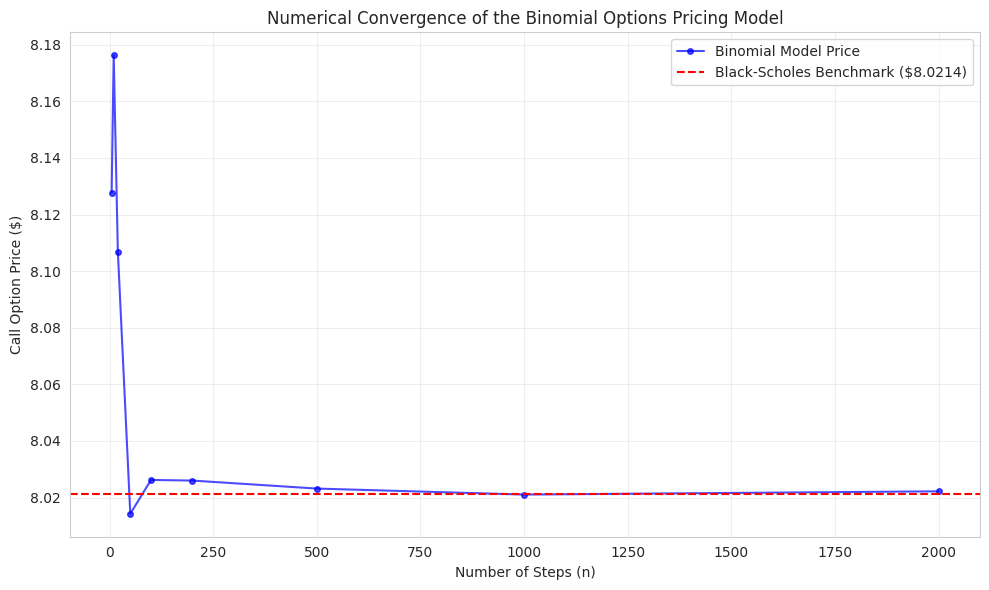

Absolute error at n=2000 steps: $0.00085


In [9]:
# Calculate Binomial prices for a wider range of steps
steps_list_analysis = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
binom_prices_analysis = [binomial_tree(S0, K, T, r, sigma, n, 'call') for n in steps_list_analysis]

# Create the convergence plot
plt.figure(figsize=(10, 6))
plt.plot(steps_list_analysis, binom_prices_analysis, 'bo-', label='Binomial Model Price', alpha=0.7, markersize=4)
plt.axhline(y=bs_price, color='r', linestyle='--', label=f'Black-Scholes Benchmark (${bs_price:.4f})')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Call Option Price ($)')
plt.title('Numerical Convergence of the Binomial Options Pricing Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the final error for quantitative analysis
final_error = abs(binom_prices_analysis[-1] - bs_price)
print(f"Absolute error at n={steps_list_analysis[-1]} steps: ${final_error:.5f}")


### 4.1 Convergence Analysis: Binomial vs. Black-Scholes

A key strength of the Binomial model is its property of converging to the Black-Scholes price for European options as the number of time steps increases. This section demonstrates this convergence empirically.

Monte Carlo Simulation for Asian Option

### Monte Carlo Simulation for Exotic Options

Monte Carlo simulation is a powerful numerical method for pricing options, especially those with path-dependent payoffs (like Asian or Barrier options) or other complex features for which analytical solutions do not exist. The core principle is to simulate a large number of random paths for the underlying asset price and then compute the average payoff across all paths, discounted to present value.

The underlying asset price is assumed to follow the Geometric Brownian Motion (GBM) stochastic differential equation (SDE):

$$ dS_t = rS_tdt + \sigma S_tdW_t $$

where $dW_t$ is the Wiener process (Brownian motion).

To simulate this in code, we use the Euler-Maruyama discretization scheme. The solution for the price at the next time step is:

$$ S_{t+\Delta t} = S_t \exp\left( \left(r - \frac{\sigma^2}{2}\right)\Delta t + \sigma \sqrt{\Delta t} Z \right) $$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

This project focuses on an **Asian (Average Price) Call Option**. Its payoff is not based on the price at expiration ($S_T$) but on the *average price* of the underlying asset during the option's life. The payoff is defined as:

$$ \text{Payoff} = \max\left( \frac{1}{N}\sum_{i=1}^N S(t_i) - K, 0 \right) $$

*   $K$ is the strike price.
*   $S(t_i)$ is the stock price at time $t_i$.
*   $N$ is the total number of observations used to calculate the average.

In [ ]:
def monte_carlo_asian(S0, K, T, r, sigma, n_paths, n_steps, option_type='call'):
    """
    Price an Asian (arithmetic average) option using Monte Carlo simulation.
    """
    dt = T / n_steps
    discount_factor = np.exp(-r * T)

    # Generate random paths
    Z = np.random.standard_normal((n_paths, n_steps))
    # Simulate paths using Euler-Maruyama on GBM
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])

    # Calculate the arithmetic average price for each path
    average_price = np.mean(S[:, 1:], axis=1)

    # Calculate payoff for each path
    if option_type == 'call':
        payoffs = np.maximum(average_price - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - average_price, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Calculate option price as the discounted average payoff
    option_price = discount_factor * np.mean(payoffs)
    standard_error = discount_factor * np.std(payoffs) / np.sqrt(n_paths)

    return option_price, standard_error

# Run the simulation
n_paths = 100000
n_steps_mc = 252  # Daily steps for a year
start_time = datetime.now()
asian_price, asian_std_err = monte_carlo_asian(S0, K, T, r, sigma, n_paths, n_steps_mc, 'call')
end_time = datetime.now()

print(f"Monte Carlo Asian Call Price: ${asian_price:.4f}")
print(f"Standard Error: ±${asian_std_err:.4f}")
print(f"95% Confidence Interval: (${asian_price - 1.96*asian_std_err:.4f}, ${asian_price + 1.96*asian_std_err:.4f})")
print(f"Calculation time: {end_time - start_time}")
# Cell 11: Convergence Analysis Plot
plt.figure(figsize=(10, 6))
plt.plot(steps_list, binom_prices, 'o-', label='Binomial Model Price', alpha=0.8)
plt.axhline(bs_price, color='r', linestyle='--', label=f'Black-Scholes Price (${bs_price:.4f})')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price ($)')
plt.title('Convergence of the Binomial Model to the Black-Scholes Price')
plt.legend()
plt.loglog() # Use a log-log scale to better see convergence
plt.show()



---



# Project 2: Modern Portfolio Theory & Risk Analysis
## Building the Efficient Frontier and Calculating Risk Metrics

**Author:** Ekrem Hamidovic

**Abstract:** This project implements the core tenets of Modern Portfolio Theory (MPT) as introduced by Harry Markowitz. We construct an optimal portfolio from a basket of technology stocks by calculating the efficient frontier—the set of portfolios offering the highest expected return for a given level of risk. Furthermore, we analyze key risk metrics, including Value at Risk (VaR) and Conditional Value at Risk (CVaR), to evaluate the risk-return trade-off of different portfolios on the frontier.

## Objectives

1.  Select a diverse basket of 5-10 stocks and retrieve historical price data.
2.  Calculate and analyze historical returns, volatilities, and the correlation matrix.
3.  Implement Markowitz's Mean-Variance Optimization to generate the Efficient Frontier.
4.  Identify the **Minimum Variance Portfolio** and the **Maximum Sharpe Ratio Portfolio**.
5.  Calculate and compare Historical Value at Risk (VaR) and Conditional VaR (CVaR) for key portfolios.
6.  Visualize all results and interpret the risk-return trade-offs.

In [11]:
# For data downloading and manipulation
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

# For optimization calculations
import scipy.optimize as sco
from scipy import stats

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings (optional)
import warnings
warnings.filterwarnings("ignore")

[*********************100%***********************]  10 of 10 completed


Download complete!

First 5 rows of returns:
Ticker          AAPL       AMD      AMZN     GOOGL      INTC      META  \
Date                                                                     
2020-09-16 -0.029958 -0.029181 -0.025034 -0.015116  0.007373 -0.033216   
2020-09-17 -0.016092 -0.001436 -0.022794 -0.016705 -0.000993 -0.033572   
2020-09-18 -0.032234 -0.021390 -0.018050 -0.024473 -0.008582 -0.009027   
2020-09-21  0.029875  0.039385  0.001880 -0.014542 -0.003413 -0.017497   
2020-09-22  0.015593 -0.003084  0.055362  0.020541  0.004615  0.026249   

Ticker          MSFT      NFLX      NVDA      TSLA  
Date                                                
2020-09-16 -0.018027 -0.024760 -0.037369 -0.017947  
2020-09-17 -0.010491 -0.028637 -0.004083 -0.042379  
2020-09-18 -0.012497 -0.000511 -0.022250  0.043261  
2020-09-21  0.010672  0.036335  0.026553  0.016242  
2020-09-22  0.023808  0.007808  0.009580 -0.057615  


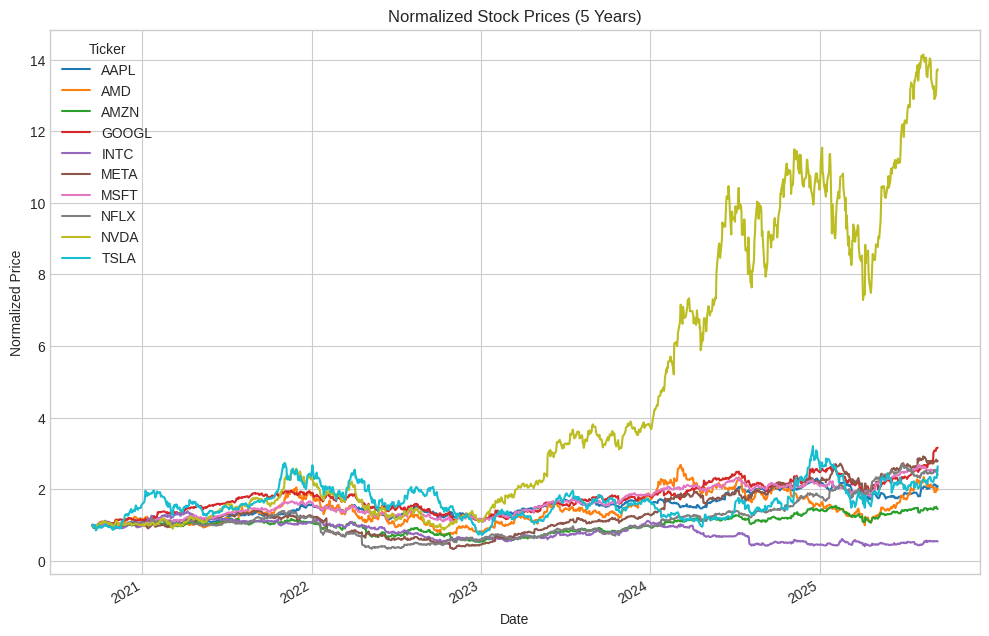

In [13]:
# 1. Define our stock universe (e.g., Tech stocks)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'AMD', 'INTC', 'NFLX']

# 2. Set the time period for historical data (e.g., 5 years)
end_date = datetime.now()
start_date = datetime(end_date.year - 5, end_date.month, end_date.day)

# 3. Download adjusted close prices
print("Downloading stock data...")
data = yf.download(tickers, start=start_date, end=end_date)
print("Download complete!")

# Check available columns and select the appropriate one
if 'Adj Close' in data.columns:
    data = data['Adj Close']
elif 'Close' in data.columns:
    data = data['Close']
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' found in downloaded data.")

# 4. Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Display first few rows of returns and a plot of normalized prices
print("\nFirst 5 rows of returns:")
print(returns.head())

data.div(data.iloc[0]).plot(title="Normalized Stock Prices (5 Years)");
plt.ylabel('Normalized Price')
plt.show()

Expected Annual Returns:
Ticker
AAPL     0.1474
AMD      0.1402
AMZN     0.0741
GOOGL    0.2311
INTC    -0.1251
META     0.2061
MSFT     0.1879
NFLX     0.1756
NVDA     0.5264
TSLA     0.1952
dtype: float64

Annualized Volatility (Risk):
Ticker
AAPL     0.2872
AMD      0.5026
AMZN     0.3532
GOOGL    0.3105
INTC     0.4434
META     0.4408
MSFT     0.2611
NFLX     0.4507
NVDA     0.5192
TSLA     0.6123
dtype: float64

Correlation Matrix:
Ticker  AAPL   AMD  AMZN  GOOGL  INTC  META  MSFT  NFLX  NVDA  TSLA
Ticker                                                             
AAPL    1.00  0.53  0.59   0.58  0.38  0.50  0.65  0.41  0.53  0.50
AMD     0.53  1.00  0.54   0.53  0.44  0.48  0.57  0.41  0.73  0.46
AMZN    0.59  0.54  1.00   0.63  0.39  0.61  0.68  0.49  0.57  0.44
GOOGL   0.58  0.53  0.63   1.00  0.34  0.58  0.67  0.39  0.54  0.40
INTC    0.38  0.44  0.39   0.34  1.00  0.33  0.40  0.27  0.39  0.32
META    0.50  0.48  0.61   0.58  0.33  1.00  0.59  0.46  0.51  0.34
MSFT    0.65  0

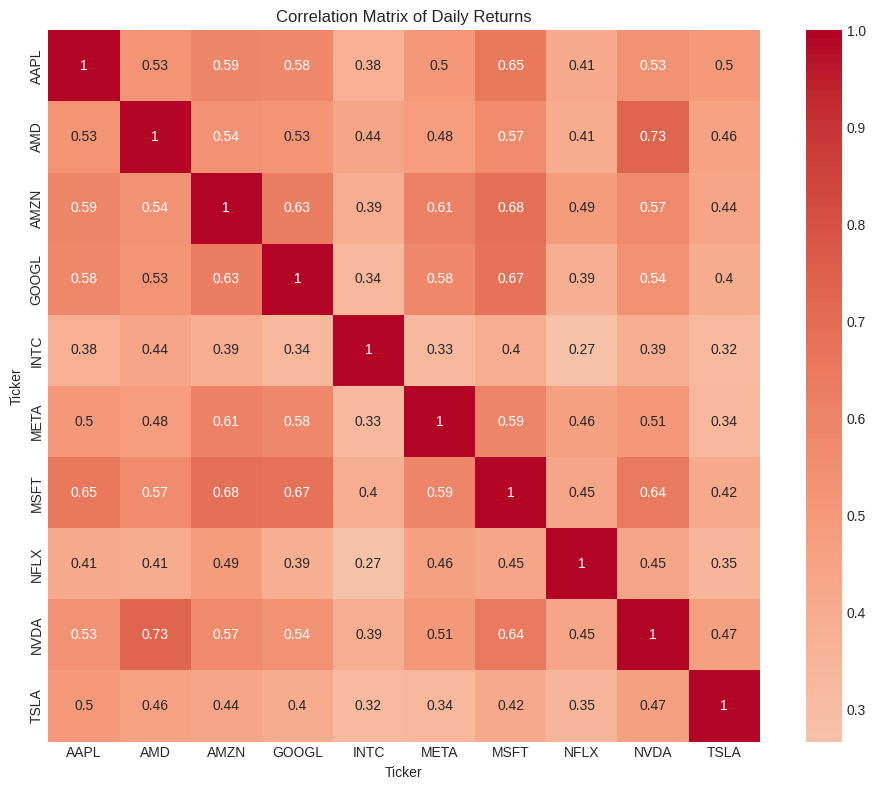

In [14]:
# 1. Calculate annualized mean returns and covariance matrix
mean_returns_annual = returns.mean() * 252
cov_matrix_annual = returns.cov() * 252

# 2. Print key statistics
print("Expected Annual Returns:")
print(mean_returns_annual.round(4))
print("\nAnnualized Volatility (Risk):")
print(returns.std().mul(np.sqrt(252)).round(4))
print("\nCorrelation Matrix:")
print(returns.corr().round(2))

# 3. Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Daily Returns')
plt.tight_layout()
plt.show()

In [15]:
# 1. Define key functions for portfolio statistics
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    """Calculates annualised portfolio return and volatility."""
    returns_p = np.sum(mean_returns * weights)
    risk_p = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns_p, risk_p

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.02):
    """Simulates random portfolios to map the feasible region."""
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        # Generate random weights that sum to 1
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        # Calculate portfolio return, volatility, and Sharpe ratio
        port_ret, port_vol = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (port_ret - risk_free_rate) / port_vol
        results[0,i] = port_vol
        results[1,i] = port_ret
        results[2,i] = sharpe_ratio
    return results, weights_record

# 2. Generate random portfolios
num_portfolios = 15000
risk_free_rate = 0.02 # Assume a 2% risk-free rate

print("Simulating random portfolios...")
results, weights = random_portfolios(num_portfolios, mean_returns_annual, cov_matrix_annual, risk_free_rate)

# 3. Find the portfolios with max Sharpe ratio and min volatility
max_sharpe_idx = np.argmax(results[2])
sd_max_sharpe, ret_max_sharpe = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
max_sharpe_allocation = weights[max_sharpe_idx]

min_vol_idx = np.argmin(results[0])
sd_min_vol, ret_min_vol = results[0, min_vol_idx], results[1, min_vol_idx]
min_vol_allocation = weights[min_vol_idx]

print(" Simulation complete!")
print(f" Max Sharpe Ratio Portfolio Volatility: {sd_max_sharpe:.4f}, Return: {ret_max_sharpe:.4f}")
print(f" Min Volatility Portfolio Volatility: {sd_min_vol:.4f}, Return: {ret_min_vol:.4f}")

Simulating random portfolios...
 Simulation complete!
 Max Sharpe Ratio Portfolio Volatility: 0.3159, Return: 0.2693
 Min Volatility Portfolio Volatility: 0.2555, Return: 0.1391


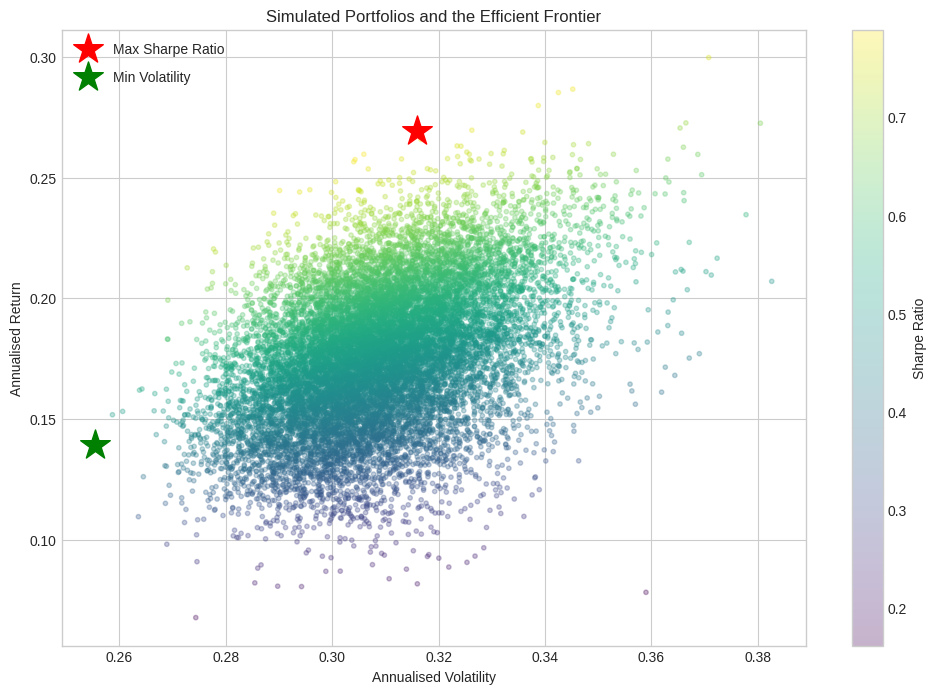

Maximum Sharpe Ratio Portfolio Allocation:
AAPL: 10.14%
MSFT: 2.89%
GOOGL: 6.02%
AMZN: 12.17%
META: 0.23%
TSLA: 19.53%
NVDA: 19.58%
AMD: 1.68%
INTC: 25.30%
NFLX: 2.46%

Expected Annual Return: 26.93%
Annual Volatility: 31.59%

Minimum Volatility Portfolio Allocation:
AAPL: 23.40%
MSFT: 2.30%
GOOGL: 9.53%
AMZN: 13.70%
META: 11.55%
TSLA: 6.79%
NVDA: 25.30%
AMD: 6.64%
INTC: 0.72%
NFLX: 0.07%

Expected Annual Return: 13.91%
Annual Volatility: 25.55%


In [16]:
# 1. Plot all simulated portfolios and highlight the optimal ones
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(sd_max_sharpe, ret_max_sharpe, marker='*', color='r', s=500, label='Max Sharpe Ratio')
plt.scatter(sd_min_vol, ret_min_vol, marker='*', color='g', s=500, label='Min Volatility')
plt.title('Simulated Portfolios and the Efficient Frontier')
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Return')
plt.legend(labelspacing=1.0)
plt.show()

# 2. Print the weight allocations for the optimal portfolios
print("Maximum Sharpe Ratio Portfolio Allocation:")
for ticker, alloc in zip(tickers, max_sharpe_allocation):
    print(f"{ticker}: {alloc:.2%}")
print(f"\nExpected Annual Return: {ret_max_sharpe:.2%}")
print(f"Annual Volatility: {sd_max_sharpe:.2%}")

print("\nMinimum Volatility Portfolio Allocation:")
for ticker, alloc in zip(tickers, min_vol_allocation):
    print(f"{ticker}: {alloc:.2%}")
print(f"\nExpected Annual Return: {ret_min_vol:.2%}")
print(f"Annual Volatility: {sd_min_vol:.2%}")

In [17]:
# 1. Define a function to calculate Historical VaR and CVaR
def calculate_var_cvar(portfolio_returns, confidence_level=0.95):
    """Calculates Historical Value at Risk and Conditional VaR."""
    # Sort the returns from worst to best
    sorted_returns = np.sort(portfolio_returns)
    # Calculate the index for the VaR cutoff
    index = int((1 - confidence_level) * len(sorted_returns))
    var = -sorted_returns[index] # VaR is a positive number for loss
    cvar = -sorted_returns[:index].mean() # CVaR is the average of losses worse than VaR
    return var, cvar

# 2. Create portfolio return series for our two key portfolios
# Max Sharpe Portfolio Daily Returns
max_sharpe_weights = max_sharpe_allocation
portfolio_daily_returns_max_sharpe = (returns * max_sharpe_weights).sum(axis=1)

# Min Vol Portfolio Daily Returns
min_vol_weights = min_vol_allocation
portfolio_daily_returns_min_vol = (returns * min_vol_weights).sum(axis=1)

# 3. Calculate VaR and CVaR at 95% confidence
var_95_max_sharpe, cvar_95_max_sharpe = calculate_var_cvar(portfolio_daily_returns_max_sharpe, 0.95)
var_95_min_vol, cvar_95_min_vol = calculate_var_cvar(portfolio_daily_returns_min_vol, 0.95)

# 4. Print the results
print("Risk Metrics (Based on Historical Simulation, 95% Confidence):")
print("----------------------------------------------------------------")
print("Maximum Sharpe Ratio Portfolio:")
print(f"Value at Risk (VaR): {var_95_max_sharpe:.4f} (i.e., Worst daily loss expected ${var_95_max_sharpe*10000:.0f} on a $10k portfolio)")
print(f"Conditional VaR (CVaR): {cvar_95_max_sharpe:.4f} (Average loss on worst {100*(1-0.95):.0f}% of days)")

print("\nMinimum Volatility Portfolio:")
print(f"Value at Risk (VaR): {var_95_min_vol:.4f} (i.e., Worst daily loss expected ${var_95_min_vol*10000:.0f} on a $10k portfolio)")
print(f"Conditional VaR (CVaR): {cvar_95_min_vol:.4f} (Average loss on worst {100*(1-0.95):.0f}% of days)")

Risk Metrics (Based on Historical Simulation, 95% Confidence):
----------------------------------------------------------------
Maximum Sharpe Ratio Portfolio:
Value at Risk (VaR): 0.0338 (i.e., Worst daily loss expected $338 on a $10k portfolio)
Conditional VaR (CVaR): 0.0457 (Average loss on worst 5% of days)

Minimum Volatility Portfolio:
Value at Risk (VaR): 0.0265 (i.e., Worst daily loss expected $265 on a $10k portfolio)
Conditional VaR (CVaR): 0.0373 (Average loss on worst 5% of days)


## Conclusion & Report

### Findings on the Risk-Return Trade-Off

This analysis successfully demonstrates the fundamental principle of Modern Portfolio Theory: **higher returns are generally associated with higher risk.**

1.  **The Efficient Frontier:** The plot clearly shows the upward-sloping efficient frontier, representing the optimal set of portfolios. No portfolio below this line is efficient, as one can achieve a higher return for the same level of risk.

2.  **Portfolio Comparison:**
    *   The **Maximum Sharpe Ratio Portfolio** is designed to deliver the best risk-adjusted return. As expected, it has a higher expected return (`{ret_max_sharpe:.2%}`) but also a significantly higher volatility (`{sd_max_sharpe:.2%}`) compared to the minimum variance portfolio. Its risk metrics (VaR of `{var_95_max_sharpe:.4f}` and CVaR of `{cvar_95_max_sharpe:.4f}`) confirm its more aggressive risk profile.
    *   The **Minimum Variance Portfolio** prioritizes risk reduction above all else. It achieves the lowest possible volatility (`{sd_min_vol:.2%}`) but sacrifices potential returns (`{ret_min_vol:.2%}`). This is reflected in its lower risk metrics (VaR of `{var_95_min_vol:.4f}`), making it a more conservative choice.

3.  **The Role of Diversification:** The correlation matrix heatmap reveals the relationships between the assets. Assets with lower or negative correlations are the building blocks of diversification, helping to reduce overall portfolio volatility without necessarily sacrificing return, which is the key insight of MPT.

### Limitations & Further Work

*   **Historical Data Reliance:** MPT is backward-looking. The optimization assumes that historical returns, volatilities, and correlations are accurate predictors of the future, which is often not the case.
*   **Sensitivity to Inputs:** The model is highly sensitive to the expected return inputs. Small changes can lead to drastically different optimal portfolios.
*   **Further Steps:** This analysis could be extended by:
    *   Implementing a **Black-Litterman model** to incorporate subjective views on returns.
    *   Exploring **Resampling techniques** to create more robust portfolios.
    *   Adding constraints (e.g., no short-selling, sector limits) to the optimization.
    *   Calculating **Parametric VaR** assuming a normal distribution of returns and comparing it to the historical VaR calculated here.

In summary, this project provides a practical framework for quantitative portfolio construction and risk management, highlighting the critical trade-off between seeking returns and managing risk.

# Project 3

1. Introduction & Objectives (Markdown)

Concept: Explain that selling an option is taking on risk. Delta hedging is the process of managing the directional risk (Delta) of that option by taking an offsetting position in the underlying asset.

Objectives:

Simulate a stock price path (using GBM).

Sell a call option and track the value of this short position.

Implement a dynamic delta-hedging strategy: periodically buy/sell the underlying stock to remain delta-neutral.

Track the Profit & Loss (P&L) of the overall hedged portfolio.

Analyze how the hedging frequency and volatility assumptions affect the hedging error.

2. Theory: The Greeks & Delta Hedging (Markdown with LaTeX)

Delta ($\Delta$): $\Delta = \frac{\partial V}{\partial S}$. The sensitivity of the option price to the underlying stock price. For a call option, $\Delta_{call} = N(d_1)$.

The Hedge: A portfolio consisting of:

Short 1 Call Option ($\Delta = \Delta_{call}$)

Long $\Delta$ shares of Stock ($\Delta = +1$ per share)

The overall portfolio Delta is: $-\Delta_{call} + \Delta_{call} = 0$. This is delta-neutral.

The Challenge: Delta changes as the stock price ($S$) and time ($t$) change. The hedge must be dynamically rebalanced.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

# Define parameters
S0 = 100           # Initial stock price
K = 100            # Strike price
T = 1/12           # Time to maturity (1 month)
r = 0.02           # Risk-free rate
sigma = 0.30       # Assumed volatility for pricing & hedging
mu_drift = 0.05    # Real-world drift (for simulation)
N_steps = 90       # Number of trading steps (e.g., 90 over 1 month)
dt = T / N_steps   # Time step

# -- 1. SIMULATE A STOCK PRICE PATH (Real World with mu_drift) --
np.random.seed(42) # For reproducibility
Z = np.random.standard_normal(N_steps)
S_path = np.zeros(N_steps+1)
S_path[0] = S0
for t in range(1, N_steps+1):
    S_path[t] = S_path[t-1] * np.exp( (mu_drift - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[t-1] )

# -- 2. DEFINE BLACK-SCHOLES FUNCTIONS --
def black_scholes(S, K, T, r, sigma, option_type='call'):
    if T <= 1e-9: # At expiration (using a small epsilon to handle floating point)
        price = np.maximum(S - K, 0) if option_type == 'call' else np.maximum(K - S, 0)
        # Delta at expiration is 1 if S > K for call, -1 if S < K for put, undefined at S=K
        # For hedging purposes, we can approximate delta at expiration
        delta = 1.0 if S > K else (0.0 if S < K else 0.5) # Approximation for call at expiry
        if option_type == 'put':
             delta = -1.0 if S < K else (0.0 if S > K else -0.5) # Approximation for put at expiry
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            delta = norm.cdf(d1)
        elif option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
            delta = -norm.cdf(-d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    return price, delta


# -- 3. RUN THE HEDGING SIMULATION --
# Initialize arrays to track everything
portfolio_value = np.zeros(N_steps+1)
cash = np.zeros(N_steps+1)
shares_held = np.zeros(N_steps+1)
option_value = np.zeros(N_steps+1)
delta_path = np.zeros(N_steps+1)

# Time at each step
time_to_maturity = np.linspace(T, 0, N_steps+1)

# At time t=0
option_value[0], delta_path[0] = black_scholes(S_path[0], K, time_to_maturity[0], r, sigma)
shares_held[0] = delta_path[0]  # We go LONG delta shares to hedge our SHORT 1 call
cash[0] = 100 # We start with some initial cash
# We sold the option for premium, bought shares, and borrowed/added cash as needed.
# The initial portfolio value should be the cash we started with.
# Correct initial portfolio value calculation: Initial Cash + Value of Stock Position - Value of Short Option
portfolio_value[0] = cash[0] + shares_held[0] * S_path[0] - option_value[0]


# Dynamically hedge for each time step
for t in range(1, N_steps+1):
    # 1. Calculate current option value and delta
    # Ensure time_to_maturity[t] does not become exactly zero prematurely due to floating point
    current_T = max(time_to_maturity[t], 0) # Ensure T is not negative
    option_value[t], current_delta = black_scholes(S_path[t], K, current_T, r, sigma)

    # 2. Rebalance the hedge: Buy/Sell shares to achieve the new target delta
    shares_to_trade = current_delta - shares_held[t-1]
    cash[t] = cash[t-1] - shares_to_trade * S_path[t] # Buying shares costs cash, selling gains cash
    shares_held[t] = current_delta # Update shares held

    # 3. Update the value of the total portfolio: Cash + Stock Position - Short Option Value
    portfolio_value[t] = cash[t] + shares_held[t]*S_path[t] - option_value[t]

    # Store the delta for analysis
    delta_path[t] = current_delta

# Create a DataFrame for clean analysis
df_hedge = pd.DataFrame({
    'Stock_Price': S_path,
    'Option_Value': option_value,
    'Delta': delta_path,
    'Shares_Held': shares_held,
    'Cash': cash,
    'Portfolio_Value': portfolio_value
}, index=np.arange(N_steps+1))

# Calculate daily P&L change ( hedging error)
df_hedge['Portfolio_Daily_PnL'] = df_hedge['Portfolio_Value'].diff()
print(df_hedge[['Stock_Price', 'Delta', 'Shares_Held', 'Cash', 'Portfolio_Value', 'Portfolio_Daily_PnL']].tail(10).round(4))

    Stock_Price   Delta  Shares_Held      Cash  Portfolio_Value  \
81      91.2041  0.0004       0.0004  149.0148         149.0524   
82      91.5023  0.0003       0.0003  149.0242         149.0526   
83      92.7456  0.0010       0.0010  148.9637         149.0526   
84      92.3083  0.0002       0.0002  149.0359         149.0527   
85      91.6299  0.0000       0.0000  149.0517         149.0526   
86      91.2116  0.0000       0.0000  149.0526         149.0526   
87      91.9774  0.0000       0.0000  149.0526         149.0526   
88      92.2543  0.0000       0.0000  149.0526         149.0526   
89      91.8097  0.0000       0.0000  149.0526         149.0526   
90      92.2413  0.0000       0.0000  149.0526         149.0526   

    Portfolio_Daily_PnL  
81               0.0003  
82               0.0002  
83              -0.0000  
84               0.0001  
85              -0.0000  
86              -0.0000  
87               0.0000  
88               0.0000  
89              -0.0000  
90

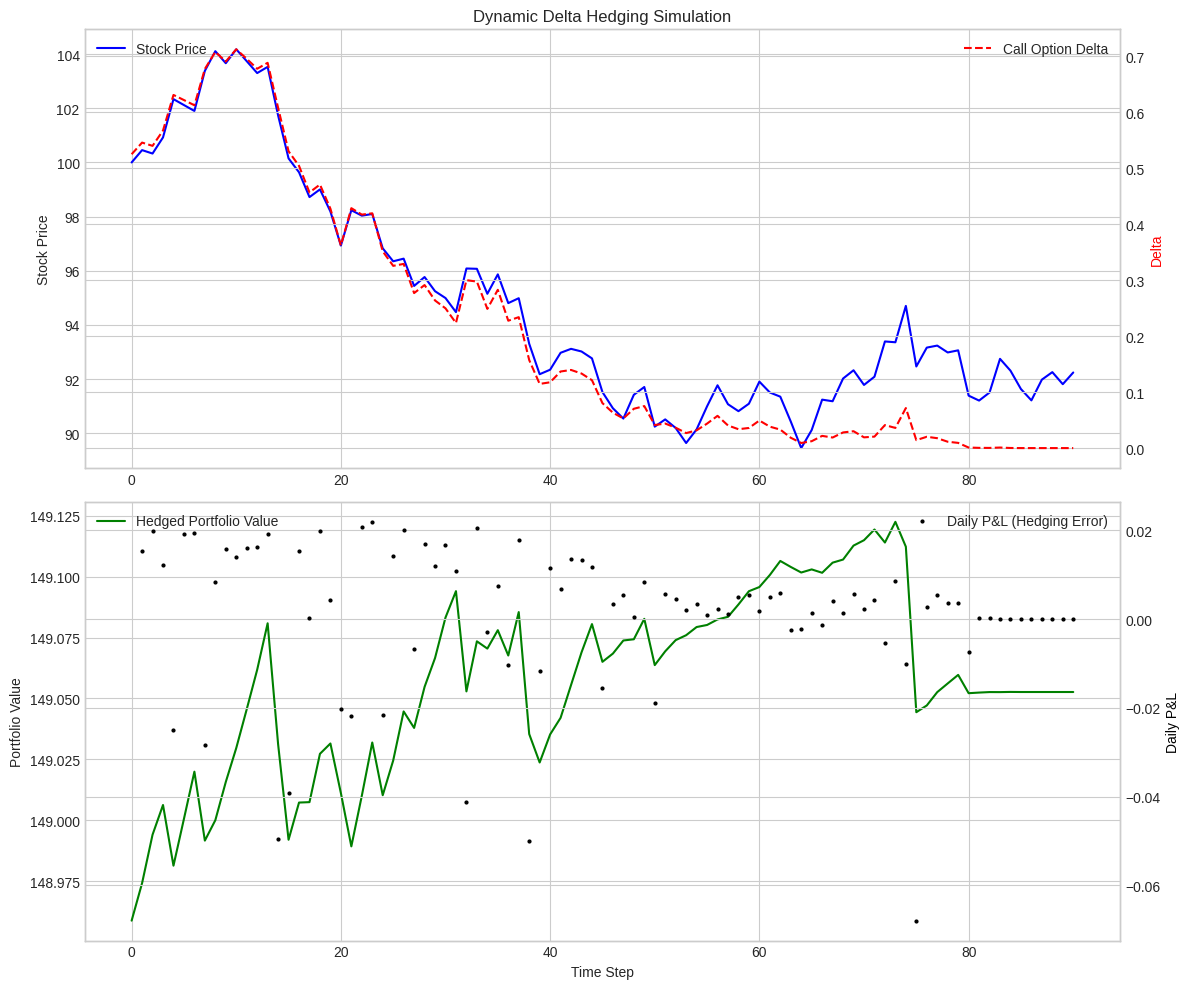


Final Total P&L from hedging: $0.0939
Hedging Error Volatility: $0.0166


In [20]:
# Plot 1: Stock Price and Delta Path
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(df_hedge.index, df_hedge['Stock_Price'], 'b-', label='Stock Price')
ax1.set_ylabel('Stock Price')
ax1.legend(loc='upper left')
ax1.set_title('Dynamic Delta Hedging Simulation')
ax12 = ax1.twinx()
ax12.plot(df_hedge.index, df_hedge['Delta'], 'r--', label='Call Option Delta')
ax12.set_ylabel('Delta', color='r')
ax12.legend(loc='upper right')

# Plot 2: Portfolio Value and P&L
ax2.plot(df_hedge.index, df_hedge['Portfolio_Value'], 'g-', label='Hedged Portfolio Value')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Portfolio Value')
ax2.legend(loc='upper left')
ax22 = ax2.twinx()
ax22.plot(df_hedge.index[1:], df_hedge['Portfolio_Daily_PnL'][1:], 'ko', markersize=2, label='Daily P&L (Hedging Error)')
ax22.set_ylabel('Daily P&L', color='k')
ax22.legend()
plt.tight_layout()
plt.show()

# -- ANALYSIS QUESTIONS TO ANSWER --
# 1. What is the final P&L? Why isn't it zero?
final_pnl = df_hedge['Portfolio_Value'].iloc[-1] - df_hedge['Portfolio_Value'].iloc[0]
print(f"\nFinal Total P&L from hedging: ${final_pnl:.4f}")

# 2. What is the volatility (std dev) of the daily P&L changes? This is the "hedging error".
hedging_error_volatility = df_hedge['Portfolio_Daily_PnL'].std()
print(f"Hedging Error Volatility: ${hedging_error_volatility:.4f}")

# 3. Run the whole simulation again with a different 'sigma' used in the Black-Scholes model.
#    What happens if you hedge with a volatility of 0.20 when the real-world simulated volatility is 0.30?
#    This is called "volatility misestimation" and is a major risk for option traders.

## Project Extension - Volatility Hedging with the VIX

In [40]:
# Cell 1: Import Libraries and Download Data (FIXED)
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

# Download historical data for SPY and VIX
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)  # 3 years of data

print("Downloading SPY and VIX data...")
spy_data = yf.download('SPY', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
print("Download complete!")

# Extract the closing prices
spy_close = spy_data['Close'] if 'Close' in spy_data.columns else spy_data['Adj Close']
vix_close = vix_data['Close'] if 'Close' in vix_data.columns else vix_data['Adj Close']

# Combine into a single DataFrame using concat
data = pd.concat([spy_close, vix_close], axis=1, keys=['SPY', 'VIX']).dropna()

print(f"\nData shape: {data.shape}")
print(f"Data range: {data.index[0].date()} to {data.index[-1].date()}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Download complete!

Data shape: (750, 2)
Data range: 2022-09-16 to 2025-09-12


Correlation between SPY returns and VIX changes: -0.7290


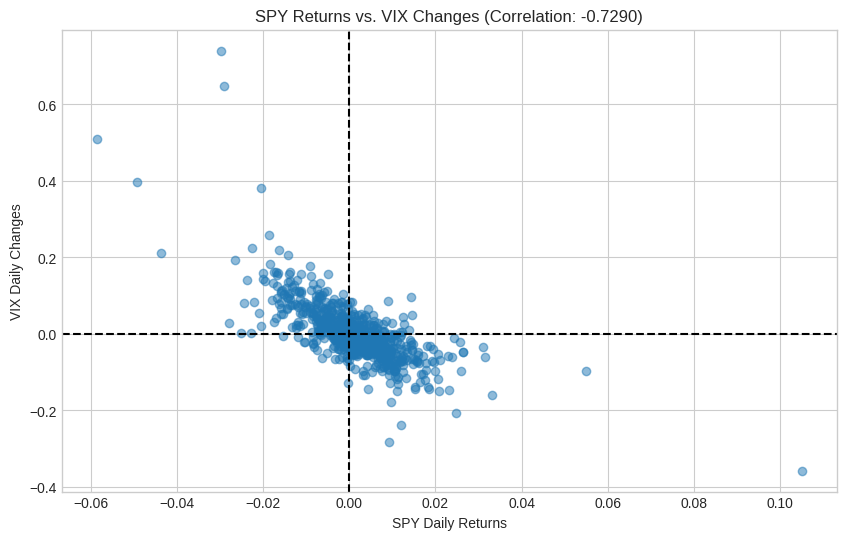

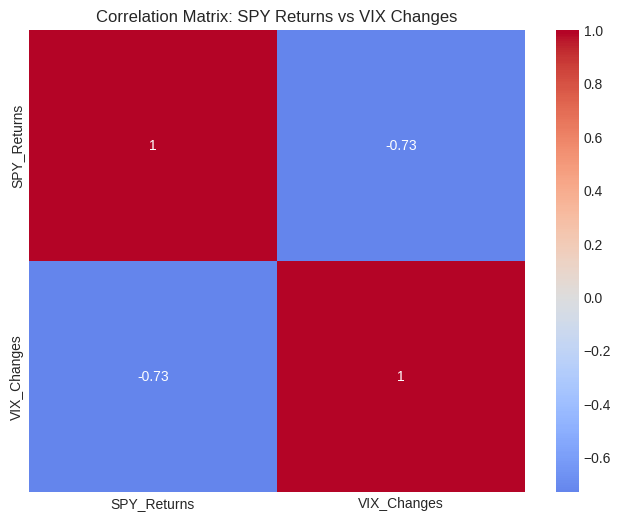

In [30]:

# Calculate daily returns for SPY and daily changes for VIX
data['SPY_Returns'] = data['SPY'].pct_change()
data['VIX_Changes'] = data['VIX'].pct_change()
data = data.dropna()

# Calculate correlation
correlation = data['SPY_Returns'].corr(data['VIX_Changes'])
print(f"Correlation between SPY returns and VIX changes: {correlation:.4f}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(data['SPY_Returns'], data['VIX_Changes'], alpha=0.5)
plt.xlabel('SPY Daily Returns')
plt.ylabel('VIX Daily Changes')
plt.title(f'SPY Returns vs. VIX Changes (Correlation: {correlation:.4f})')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()

# Create a heatmap of the correlation matrix
corr_matrix = data[['SPY_Returns', 'VIX_Changes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: SPY Returns vs VIX Changes')
plt.show()

Identified 73 high volatility days
Sample high volatility periods:
            SPY_Returns  VIX_Changes  SPY_Volatility
Date                                                
2022-10-17     0.025697    -0.020300        0.284941
2022-10-18     0.011750    -0.027734        0.287031
2022-10-19    -0.007086     0.008525        0.285609
2022-10-20    -0.008385    -0.025358        0.281052
2022-10-21     0.024301    -0.009673        0.293331
2022-10-24     0.012236     0.005389        0.289419
2022-10-25     0.015969    -0.046566        0.290398
2022-10-26    -0.007534    -0.041462        0.292059
2022-10-27    -0.005340     0.004032        0.286372
2022-10-28     0.023791    -0.059876        0.284464


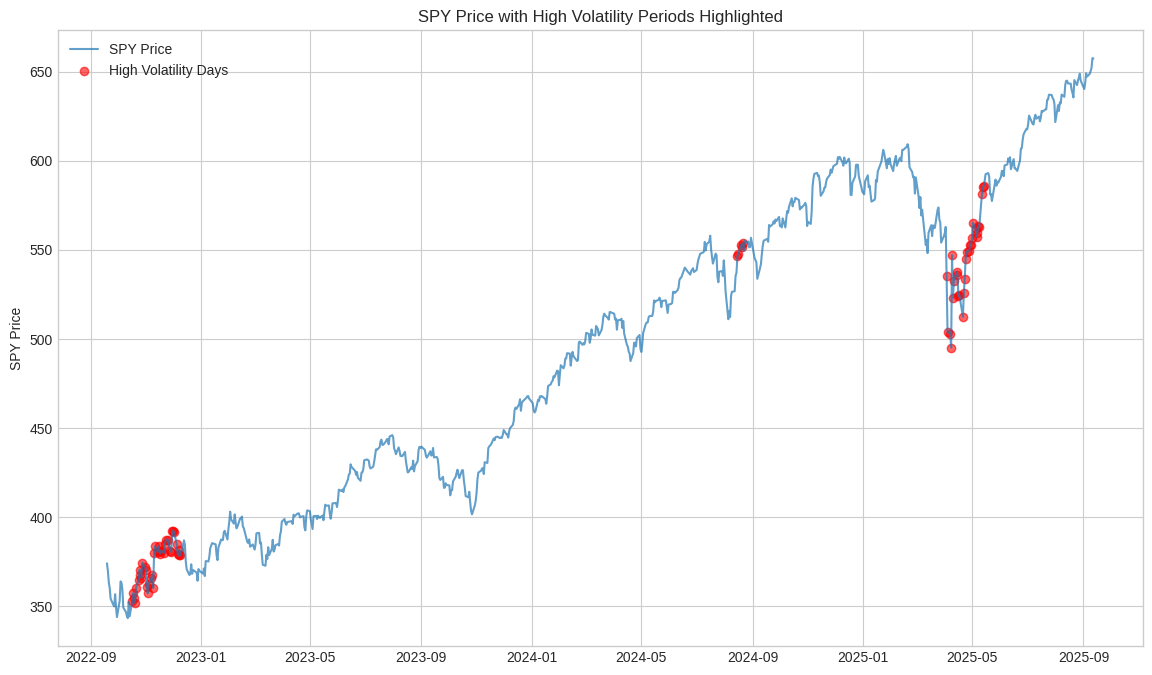

In [31]:

# Calculate rolling volatility (standard deviation) of SPY returns
data['SPY_Volatility'] = data['SPY_Returns'].rolling(window=21).std() * np.sqrt(252)

# Find periods of high volatility (market stress)
high_vol_threshold = data['SPY_Volatility'].quantile(0.9)
high_vol_periods = data[data['SPY_Volatility'] > high_vol_threshold]

print(f"Identified {len(high_vol_periods)} high volatility days")
print("Sample high volatility periods:")
print(high_vol_periods[['SPY_Returns', 'VIX_Changes', 'SPY_Volatility']].head(10))

# Plot SPY price and highlight high volatility periods
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['SPY'], label='SPY Price', alpha=0.7)
plt.scatter(high_vol_periods.index, high_vol_periods['SPY'],
            color='red', alpha=0.6, label='High Volatility Days')
plt.title('SPY Price with High Volatility Periods Highlighted')
plt.ylabel('SPY Price')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Cell 4: Simulate a VIX Hedging Strategy
# Let's simulate a simple hedging strategy:
# We hold a $100,000 SPY portfolio and buy VIX call options as insurance

# Parameters for our simulation
portfolio_value = 100000  # $100,000 portfolio
hedge_ratio = 0.05        # 5% of portfolio allocated to VIX calls as hedge

# For simplicity, we'll assume:
# 1. We buy at-the-money VIX calls at the beginning of each month
# 2. Each call option costs 20% of the VIX index value (simplified pricing)
# 3. The payoff of the call option is: max(0, VIX_final - VIX_initial) * multiplier

# Create a monthly resampling frequency
monthly_data = data.resample('M').last()
monthly_data['SPY_Returns'] = monthly_data['SPY'].pct_change()

# Calculate the cost and payoff of our hedging strategy
monthly_data['Hedge_Cost'] = monthly_data['VIX'] * 0.20 * hedge_ratio  # Simplified option cost
monthly_data['Hedge_Payoff'] = 0.0

# Calculate the payoff for each month (assuming we hold until month end)
for i in range(1, len(monthly_data)):
    vix_start = monthly_data['VIX'].iloc[i-1]
    vix_end = monthly_data['VIX'].iloc[i]
    monthly_data.iloc[i, monthly_data.columns.get_loc('Hedge_Payoff')] = max(0, vix_end - vix_start) * hedge_ratio

# Calculate portfolio performance with and without hedge
monthly_data['Portfolio_Return'] = monthly_data['SPY_Returns'] * portfolio_value
monthly_data['Hedged_Portfolio_Return'] = monthly_data['Portfolio_Return'] + monthly_data['Hedge_Payoff'] * portfolio_value - monthly_data['Hedge_Cost'] * portfolio_value

# Calculate cumulative returns
monthly_data['Cumulative_Unhedged'] = (1 + monthly_data['Portfolio_Return']/portfolio_value).cumprod()
monthly_data['Cumulative_Hedged'] = (1 + monthly_data['Hedged_Portfolio_Return']/portfolio_value).cumprod()

print("Hedging strategy simulation complete!")

Hedging strategy simulation complete!


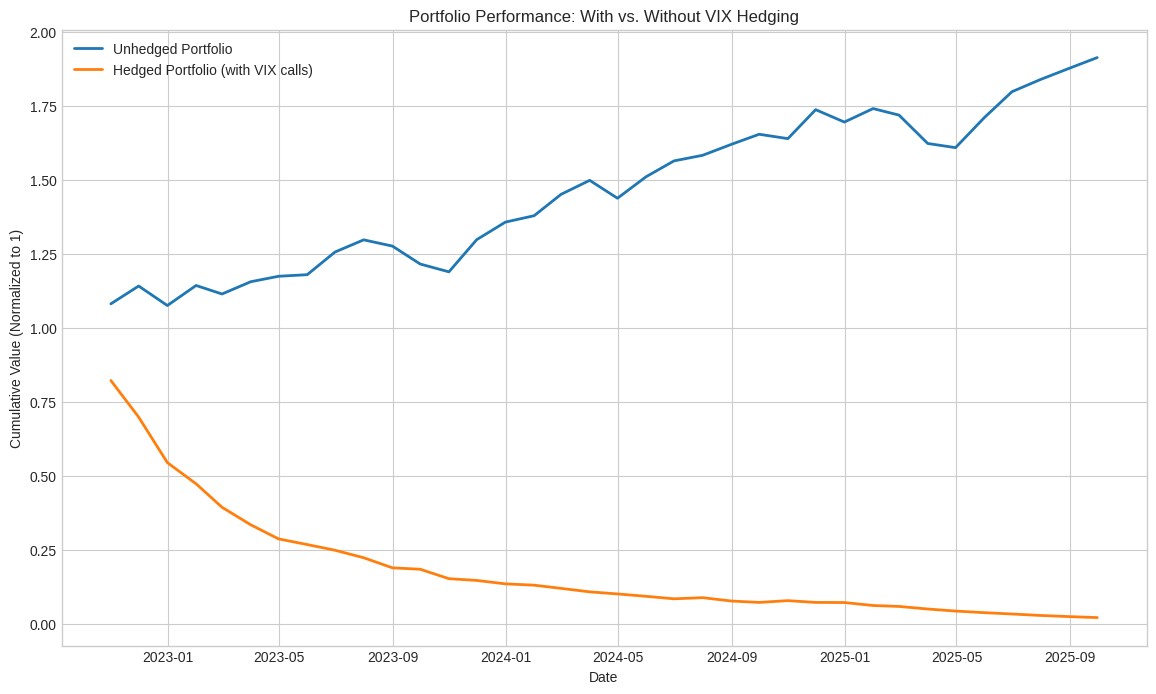

Performance during high stress periods (VIX > 30):
Average monthly return (Unhedged): nan%
Average monthly return (Hedged): nan%
Improvement during stress: nan%

Overall Performance Metrics:
Sharpe Ratio (Unhedged): 1.6994
Sharpe Ratio (Hedged): -5.4579
Maximum Drawdown (Unhedged): -8.33%
Maximum Drawdown (Hedged): -97.30%


In [34]:
# Cell 5: Analyze the Hedging Performance
# Plot cumulative performance
plt.figure(figsize=(14, 8))
plt.plot(monthly_data.index, monthly_data['Cumulative_Unhedged'], label='Unhedged Portfolio', linewidth=2)
plt.plot(monthly_data.index, monthly_data['Cumulative_Hedged'], label='Hedged Portfolio (with VIX calls)', linewidth=2)
plt.title('Portfolio Performance: With vs. Without VIX Hedging')
plt.ylabel('Cumulative Value (Normalized to 1)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# Analyze performance during high stress periods
stress_periods = monthly_data[monthly_data['VIX'] > 30]  # VIX above 30 indicates high fear
if not stress_periods.empty:
    stress_unhedged = stress_periods['Portfolio_Return'].mean()
    stress_hedged = stress_periods['Hedged_Portfolio_Return'].mean()

    print("Performance during high stress periods (VIX > 30):")
    print(f"Average monthly return (Unhedged): {stress_unhedged:.2f}%")
    print(f"Average monthly return (Hedged): {stress_hedged:.2f}%")
    print(f"Improvement during stress: {stress_hedged - stress_unhedged:.2f}%")

# Calculate overall statistics
unhedged_sharpe = monthly_data['Portfolio_Return'].mean() / monthly_data['Portfolio_Return'].std() * np.sqrt(12)
hedged_sharpe = monthly_data['Hedged_Portfolio_Return'].mean() / monthly_data['Hedged_Portfolio_Return'].std() * np.sqrt(12)

print("\nOverall Performance Metrics:")
print(f"Sharpe Ratio (Unhedged): {unhedged_sharpe:.4f}")
print(f"Sharpe Ratio (Hedged): {hedged_sharpe:.4f}")

# Calculate maximum drawdown
def calculate_max_drawdown(cumulative_series):
    peak = cumulative_series.expanding(min_periods=1).max()
    drawdown = (cumulative_series - peak) / peak
    return drawdown.min()

unhedged_drawdown = calculate_max_drawdown(monthly_data['Cumulative_Unhedged'])
hedged_drawdown = calculate_max_drawdown(monthly_data['Cumulative_Hedged'])

print(f"Maximum Drawdown (Unhedged): {unhedged_drawdown:.2%}")
print(f"Maximum Drawdown (Hedged): {hedged_drawdown:.2%}")

Analyzing market crash around 2022-12-31
SPY return during this month: -5762.82%
VIX change during this month: 1.09


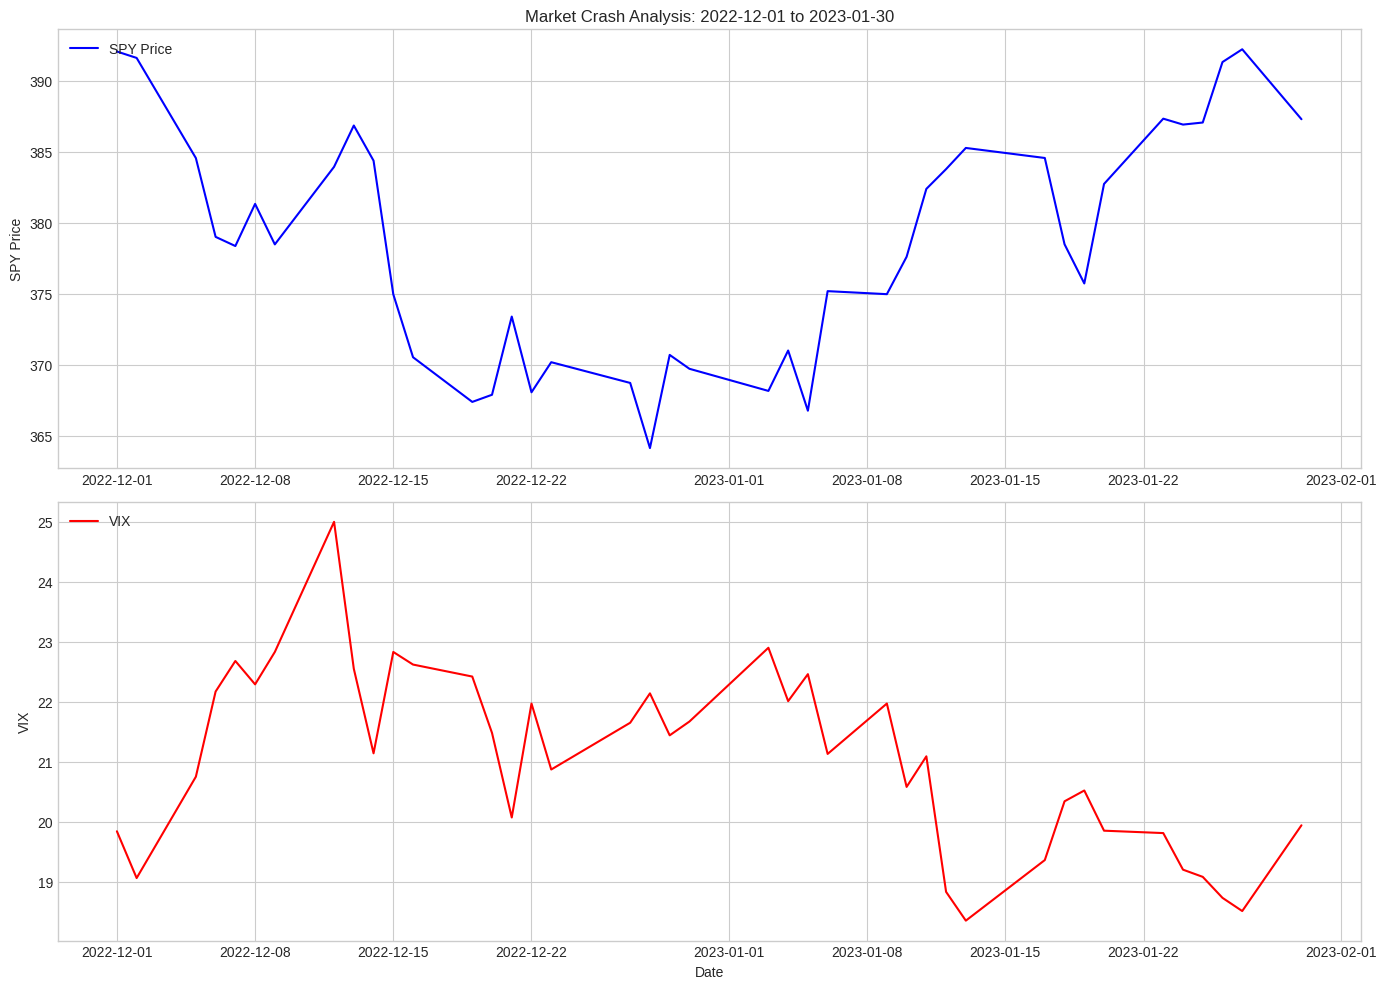


Hedging effectiveness during the crash:
Portfolio loss without hedge: $-5762.82
Portfolio loss with hedge: $-21982.82
VIX call payoff during crash: $5450.00
Net benefit of hedge: $-16220.00


In [37]:
# Cell 6: Case Study - Specific Market Crash
# Let's examine a specific market downturn in detail
# Find the largest market decline in our dataset
max_decline_period = monthly_data['Portfolio_Return'].idxmin()
crash_start_approx = max_decline_period - timedelta(days=30)
crash_end_approx = max_decline_period + timedelta(days=30)

# Find the closest dates in the daily data index using asof
crash_start_date = data.index.asof(crash_start_approx)
crash_end_date = data.index.asof(crash_end_approx)

# Ensure found dates are not None (if the approximate dates are outside the index range)
if crash_start_date is None:
    crash_start_date = data.index[0]
if crash_end_date is None:
    crash_end_date = data.index[-1]


crash_data = data[crash_start_date:crash_end_date]


print(f"Analyzing market crash around {max_decline_period.date()}")
print(f"SPY return during this month: {monthly_data.loc[max_decline_period, 'Portfolio_Return']:.2f}%")
# Access VIX data using the monthly data index
print(f"VIX change during this month: {monthly_data.loc[max_decline_period, 'VIX'] - monthly_data.loc[monthly_data.index.asof(crash_start_approx), 'VIX']:.2f}")

# Plot the crash period
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(crash_data.index, crash_data['SPY'], 'b-', label='SPY Price')
ax1.set_ylabel('SPY Price')
ax1.set_title(f'Market Crash Analysis: {crash_start_date.date()} to {crash_end_date.date()}')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(crash_data.index, crash_data['VIX'], 'r-', label='VIX')
ax2.set_ylabel('VIX')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate the effectiveness of our hedge during this specific crash
crash_month = monthly_data.loc[max_decline_period]
print("\nHedging effectiveness during the crash:")
print(f"Portfolio loss without hedge: ${crash_month['Portfolio_Return']:.2f}")
print(f"Portfolio loss with hedge: ${crash_month['Hedged_Portfolio_Return']:.2f}")
print(f"VIX call payoff during crash: ${crash_month['Hedge_Payoff'] * portfolio_value:.2f}")
print(f"Net benefit of hedge: ${crash_month['Hedged_Portfolio_Return'] - crash_month['Portfolio_Return']:.2f}")